In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import json
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz

from sklearn.mixture import GaussianMixture

from my_utils import *

#### Prepare data

In [ ]:
def get_data(train_filename: str, test_filename: str, features: list) -> dict:
    # Read data
    df_train = pd.read_csv(train_filename)
    df_test = pd.read_csv(test_filename)

    # Select target and features
    use_cols = ["precision"] + features
    df_train = df_train[use_cols]
    df_test = df_test[use_cols]
    
    # Transform precision to binary
    df_train["precision"] = (df_train["precision"] == 1).astype(int)
    df_test["precision"] = (df_test["precision"] == 1).astype(int)

    return df_train, df_test

#### Supervised Classification

In [ ]:
def get_outputs(model, train, test, features) -> tuple:

    # Create and train the logistic regression model
    clf = model.fit(train[features], train["precision"])

    # Save the trained model as a pickle file
    with open("outputs/models/clf_logistic.pickle", 'wb') as f:
        pickle.dump(model, f)
    
    # Make predictions on the test set
    preds = clf.predict(test[features])

    return preds, test["precision"]

In [ ]:
def save_confusion_matrix(truths, preds, filename: str) -> None:
    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(truths, preds).ravel()

    # Structure data for json dump
    json_data = {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}

    # Save the confusion matrix as json
    with open(filename, 'w') as f:
        json.dump(json_data, f)


In [ ]:
def get_roc_curve(truths, scores, filename: str) -> None:
    # Calculate the roc curve
    fpr, tpr, thresholds = roc_curve(truths, scores)

    # ---- Plot the result ----
    
    # Initilize the plot
    fig, ax = plt.subplots()

    # Label the axes
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

    # Set the title
    ax.set_title('ROC Curve for Trained Classifier')

    # Plot the data
    ax.plot(fpr, tpr)

    # Save the plot
    fig.savefig(filename)


In [ ]:
features = [
    # "country_code",
    "weather",
    # "road_type",
    # "road_condition",
    "time_of_day",
    # "num_vehicles",
    # "longitude",
    # "latitude",
    "solar_angle_elevation",
    # "focal_length_x",
    # "focal_length_y",
    # "principle_point_x",
    # "principle_point_y",
    # "camera_pose_x",
    # "camera_pose_y",
    # "camera_pose_z",
    # "camera_pose_yaw",
    # "camera_pose_pitch",
    # "camera_pose_roll",
    # "horizontal_fov",
    # "vertical_fov",
    # "ego_pose_x",
    # "ego_pose_y",
    # "ego_pose_z",
    # "ego_pose_yaw",
    # "ego_pose_pitch",
    # "ego_pose_roll",
    # "speed_var",
    # "mean_jerk",
    # "max_jerk",
    # "st_jerk",
    # "mean_angular_acc",
    # "max_angular_acc",
    # "st_angular_acc",
    # "mean_lateral_acc",
    # "max_lateral_acc",
    # "st_lateral_acc",
    "luminance",
    "contrast",
    "saturation",
    "sharpness",
    "temperature",
    "edge_density", 
    "entropy"
]

# Get the data
train, test = get_data("classification_train.csv", "classification_test.csv", features)

# Define the model
models = {
    "SVM": SVC(max_iter=5000),
    "Decision_Tree": DecisionTreeClassifier(min_samples_leaf=1000, max_features=15),
    "Random_Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=25),
    "Naive_Bayes": GaussianNB(),
    "Logistic": LogisticRegression(),
}

# # Feature selection
# pipeline_a = Pipeline([
#     ("scaler", StandardScaler()),
#     ("logreg", LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000))
# ])
# pipeline_a.fit(train[features], train["precision"])

# # Check which features are selected
# model = pipeline_a.named_steps["logreg"]
# selected_features = np.where(model.coef_[0] != 0)[0]

# print("Selected feature indices:", selected_features)
# print("Total selected:", len(selected_features), "/", len(features))

pipeline_b = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", models["Logistic"])
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10, 100],
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs"],  # or "liblinear" for l1
    "logreg__max_iter": [500, 1000, 2000]
}

grid = GridSearchCV(pipeline_b, param_grid, cv=5, scoring="accuracy")

# Obtain predictions and test labels of the logistic regression model
preds, truths = get_outputs(grid, train, test, features)

print("Best params:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

acc = accuracy_score(truths, preds)
print(f"Accuracy: {acc:.4f}")

# --- Compute the confidence score ----
# Load the trained classified
with open("outputs/models/clf_logistic.pickle", "rb") as f:
    clf: LogisticRegression = pickle.load(f)

# Calculate the decision score using the test data
scores = clf.decision_function(test[features])
auc = roc_auc_score(truths, scores)
print(f"AUC: {auc:.4f}")

# Save confusion matrix and ROC curve
save_confusion_matrix(truths, preds, "outputs/models/clf_logistic_confusion_matrix.json")
get_roc_curve(truths, scores, "outputs/models/clf_logistic_roc.pdf")

#### Unsupervised Clustering

In [2]:
# Define feature usages
lighting = ["weather", 
            "time_of_day", 
            # "solar_angle_elevation", 
            # "road_condition"
            ]

color_profile = [
    "luminance",
    "contrast",
    "saturation",
    "sharpness",
    "temperature",
    "edge_density",
    "entropy",
]

calibration = [
    "focal_length_x",
    "focal_length_y",
    "principle_point_x",
    "principle_point_y",
    "camera_pose_x",
    "camera_pose_y",
    "camera_pose_z",
    "camera_pose_yaw",
    "camera_pose_pitch",
    "camera_pose_roll",
    "horizontal_fov",
    "vertical_fov",
]

ego_motion = [
    "ego_pose_x",
    "ego_pose_y",
    "ego_pose_z",
    "ego_pose_yaw",
    "ego_pose_pitch",
    "ego_pose_roll",
    "speed_var",
    "mean_jerk",
    "max_jerk",
    "st_jerk",
    "mean_angular_acc",
    "max_angular_acc",
    "st_angular_acc",
    "mean_lateral_acc",
    "max_lateral_acc",
    "st_lateral_acc",
]
others = [
    "country_code",
    "road_type",
    "num_vehicles",
    "longitude",
    "latitude",
]

features = lighting + color_profile

In [3]:
# Data Preperation
df_train = pd.read_csv("train_test_data/8_train.csv")
df_test = pd.read_csv("train_test_data/2_test.csv")

# Training samples
X = df_train[features].to_numpy()

# Preprocess the data (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction
pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(X_scaled)

K-means

In [ ]:

# Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_reduced)
labels = kmeans.labels_

# Evaluation using Silhouette Score
score = silhouette_score(X_reduced, labels)
print(f"Silhouette Score: {score:.3f}")

# Save model
with open("outputs/models/clustering/kmeans_2_cluster.pkl", "wb") as f:
    pickle.dump(kmeans, f)


Silhouette Score: 0.617


Fuzzy C means

In [ ]:
# Transpose X for skfuzzy (shape: features × samples)
X_reduced_T = X_reduced.T

# Apply fuzzy c-means
n_clusters = 2
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_reduced_T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
)

# u: membership matrix, shape (n_clusters, n_samples)
# Get the most likely cluster for each sample
labels = np.argmax(u, axis=0)

# Save the model
with open("outputs/models/clustering/kmeans_fuzzy_2_cluster.pkl", "wb") as f:
    pickle.dump({"cntr": cntr, "m": 2}, f)

print(f"Fuzzy Partition Coefficient (FPC): {fpc:.3f}")

Gaussian Mixture Model

In [4]:
gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=42)
gmm.fit(X_reduced)

# Predict cluster labels
labels = gmm.predict(X_reduced)

# Evaluate clustering quality (e.g., silhouette score)
score = silhouette_score(X_reduced, labels)
print(f"Silhouette Score: {score:.3f}")

# Save the model and preprocessing pipeline
with open("outputs/models/clustering/gmm_2_cluster.pkl", "wb") as f:
    pickle.dump({"model": gmm, "scaler": scaler, "pca": pca}, f)

Silhouette Score: 0.052


Evaluation

In [8]:
model = "gmm"

# Test the model
X_test = df_test[features].to_numpy()

# Preprocess the data (scaling)
X_test_scaled = scaler.fit_transform(X_test)

# Dimensionality Reduction
X_test_reduced = pca.fit_transform(X_test_scaled)

# Clustering
if model == "kmeans":
    kmeans.fit(X_test_reduced)
    labels = kmeans.labels_

if model == "gmm":
    labels = gmm.predict(X_test_reduced)

# Evaluation using Silhouette Score
score = silhouette_score(X_test_reduced, labels)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.091


In [9]:
# Check the precision score for the two clusters
kpis = ["recall", "accuracy", "precision"]
cluster_0 = df_test[labels==0]
cluster_1 = df_test[labels==1]

print(cluster_0[kpis].describe())
print(cluster_1[kpis].describe())


            recall    accuracy    precision
count  2277.000000  2277.00000  2277.000000
mean      0.447059     0.70546     0.849108
std       0.245988     0.18555     0.211069
min       0.000000     0.00000     0.000000
25%       0.267000     0.57100     0.750000
50%       0.400000     0.72200     1.000000
75%       0.571000     0.84600     1.000000
max       1.000000     1.00000     1.000000
           recall    accuracy   precision
count  803.000000  803.000000  803.000000
mean     0.429818    0.704248    0.820374
std      0.264934    0.195194    0.286722
min      0.000000    0.000000    0.000000
25%      0.232000    0.587000    0.750000
50%      0.417000    0.727000    1.000000
75%      0.581000    0.848000    1.000000
max      1.000000    1.000000    1.000000


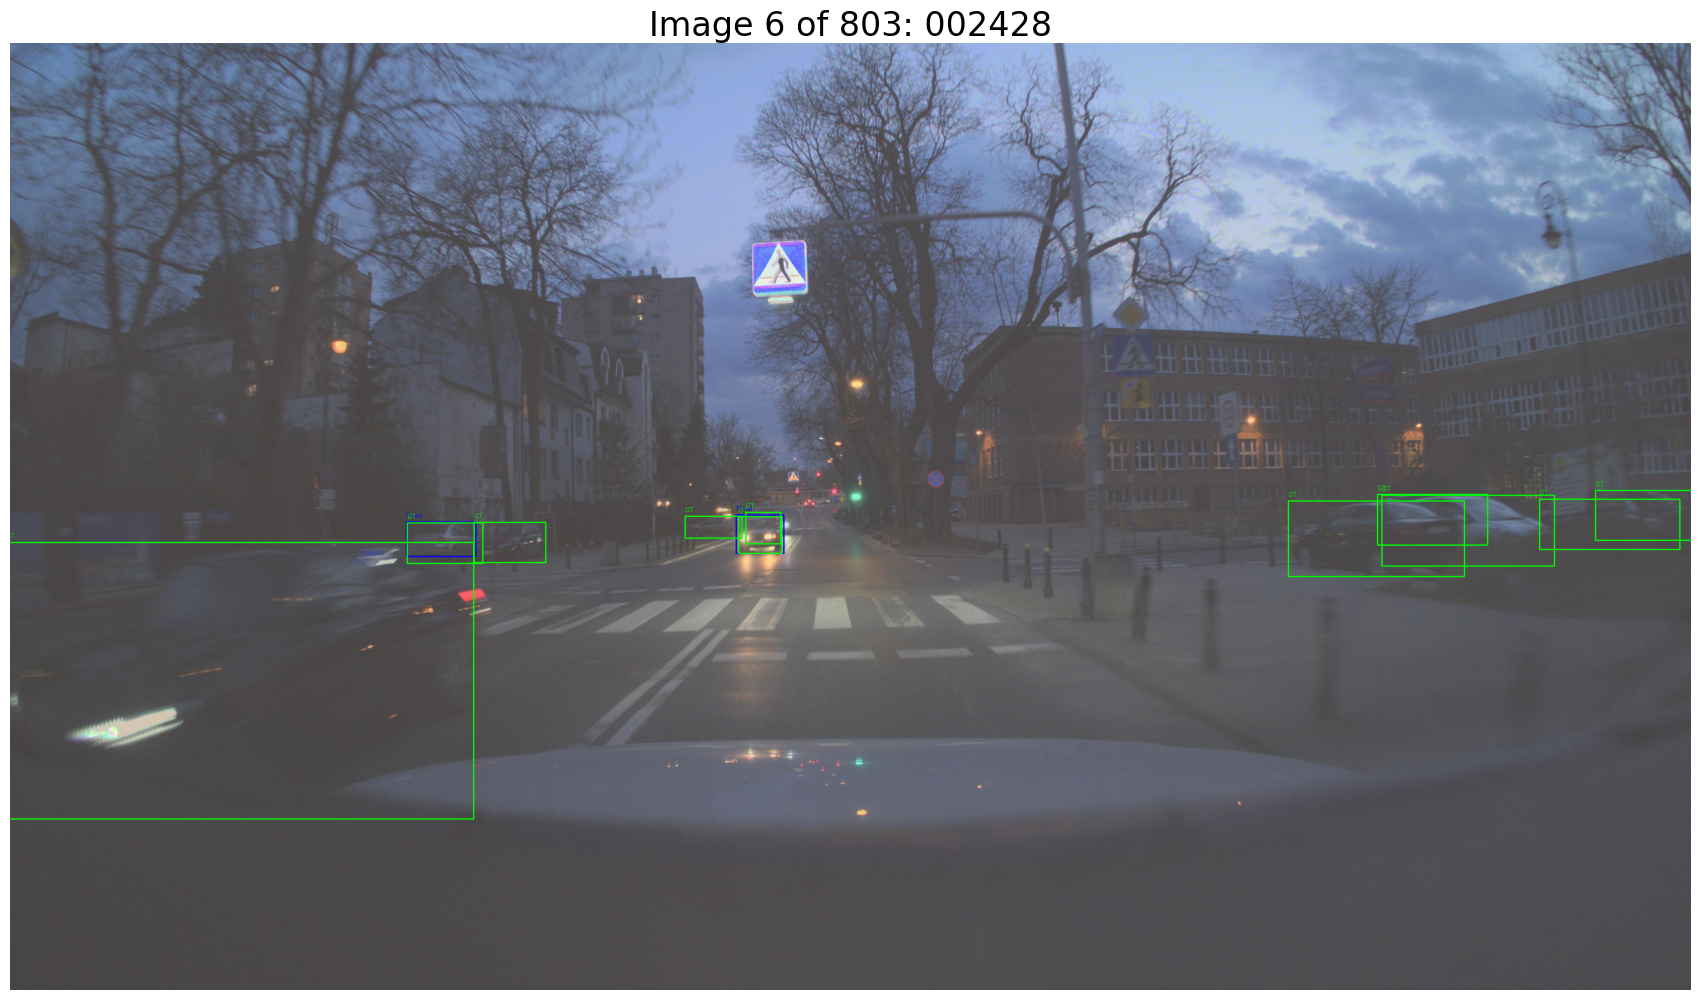

In [10]:
# Check cluster 1 images mannually
image_path_cluster_1 = cluster_1["image_path"].to_list()
image_id_cluster_1 = cluster_1["image_id"].to_list()

# Get pred bboxes and gt bboxes
starts = [1 + 5000 * i for i in range(10)]
pred_subs = []
gt_subs = []

for start in starts:
    end = start + 5000 - 1
    
    pred_subs.append(pd.read_csv(f"outputs/{start}_{end}/predictions.csv"))
    gt_subs.append(pd.read_csv(f"outputs/{start}_{end}/ground_truths.csv"))

preds = pd.concat(pred_subs, axis=0)
gts = pd.concat(gt_subs, axis=0)
gts = gts[gts["class"]=="Vehicle"]

gt_bboxes = []
pred_bboxes = []
for idx, image_id in enumerate(image_id_cluster_1):
    gt_bboxes.append(gts[gts["image_id"]==image_id].iloc[:, 1:5].to_numpy())
    pred_bboxes.append(preds[preds["image_id"]==image_id].iloc[:, 1:5].to_numpy())


navigate_images(image_path_cluster_1, 0, pred_bboxes, gt_bboxes)

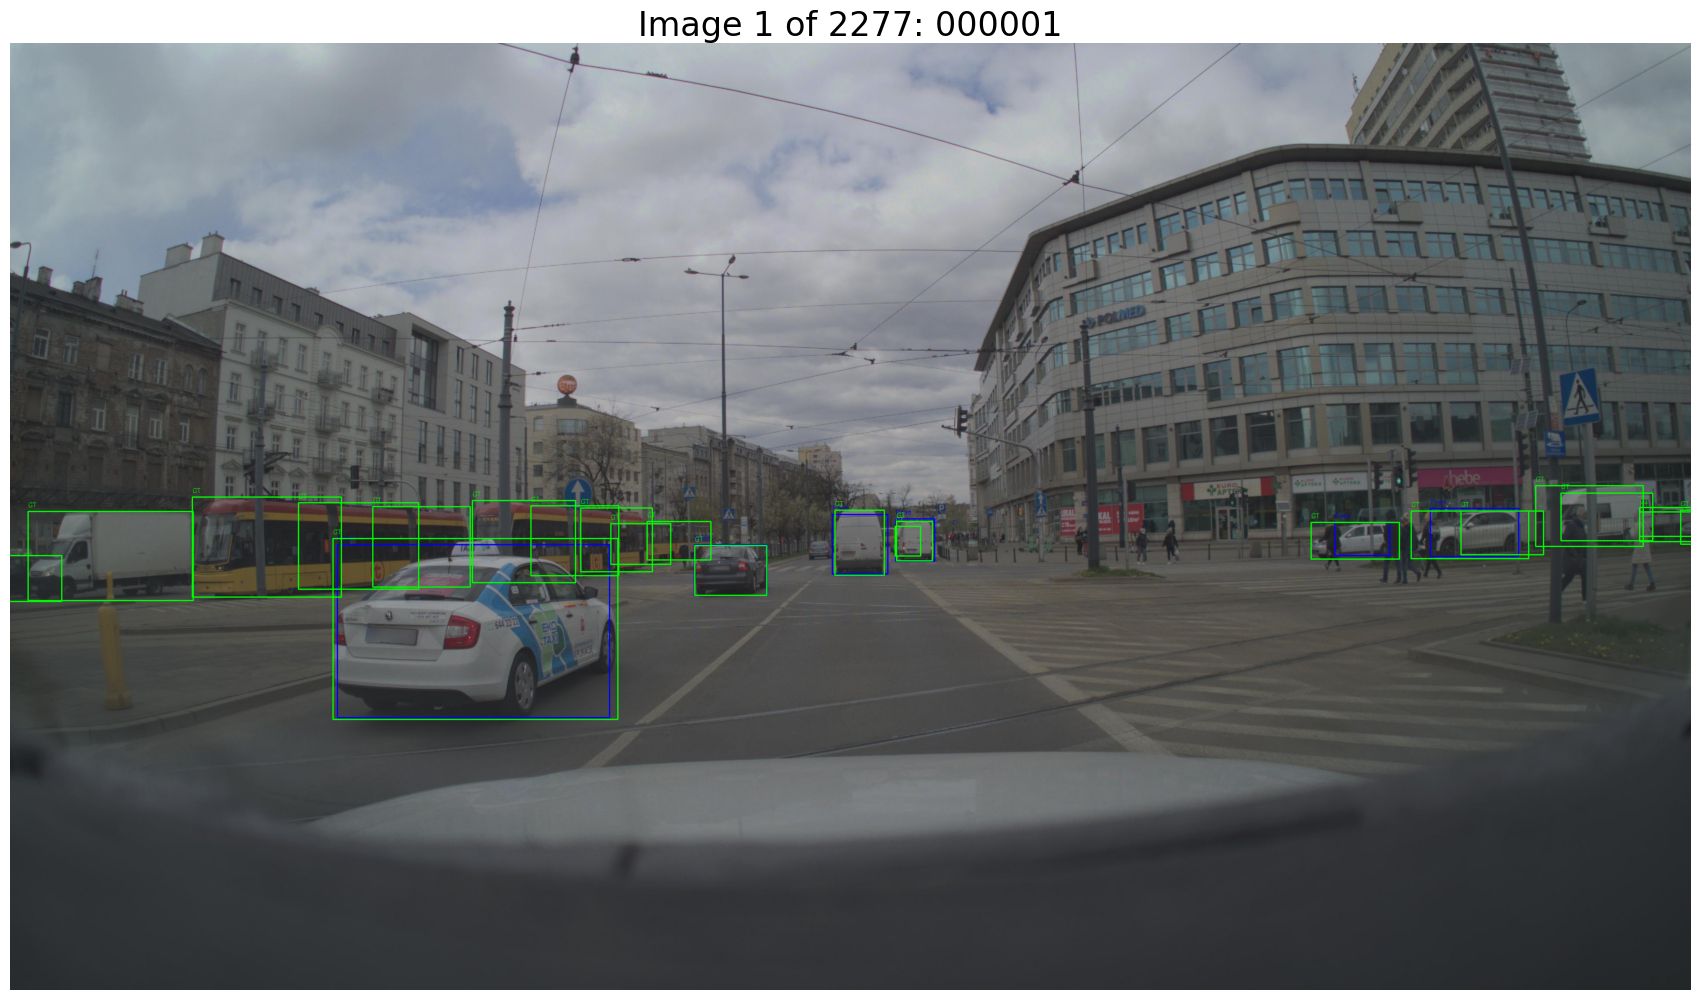

In [11]:
# Check cluster 0 images mannually
image_path_cluster_0 = cluster_0["image_path"].to_list()
image_id_cluster_0 = cluster_0["image_id"].to_list()

# Get pred bboxes and gt bboxes
starts = [1 + 5000 * i for i in range(10)]
pred_subs = []
gt_subs = []

for start in starts:
    end = start + 5000 - 1
    
    pred_subs.append(pd.read_csv(f"outputs/{start}_{end}/predictions.csv"))
    gt_subs.append(pd.read_csv(f"outputs/{start}_{end}/ground_truths.csv"))

preds = pd.concat(pred_subs, axis=0)
gts = pd.concat(gt_subs, axis=0)
gts = gts[gts["class"]=="Vehicle"]

gt_bboxes = []
pred_bboxes = []
for idx, image_id in enumerate(image_id_cluster_0):
    gt_bboxes.append(gts[gts["image_id"]==image_id].iloc[:, 1:5].to_numpy())
    pred_bboxes.append(preds[preds["image_id"]==image_id].iloc[:, 1:5].to_numpy())


navigate_images(image_path_cluster_0, 0, pred_bboxes, gt_bboxes)